In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

correct_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
print(os.listdir(correct_path))

['train', 'val', 'test']


In [5]:
print("Train folders:", os.listdir(correct_path + '/train'))
print("Val folders:", os.listdir(correct_path + '/val'))
print("Test folders:", os.listdir(correct_path + '/test'))

Train folders: ['PNEUMONIA', 'NORMAL']
Val folders: ['PNEUMONIA', 'NORMAL']
Test folders: ['PNEUMONIA', 'NORMAL']


In [6]:
import os

base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'

splits = ['train', 'val', 'test']
classes = ['PNEUMONIA', 'NORMAL']

for split in splits:
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{split.capitalize()} - {cls}: {count} images")


Train - PNEUMONIA: 3818 images
Train - NORMAL: 1403 images
Val - PNEUMONIA: 1135 images
Val - NORMAL: 418 images
Test - PNEUMONIA: 1141 images
Test - NORMAL: 415 images


In [7]:
import tensorflow as tf
print("🚀 GPU Available:", tf.config.list_physical_devices('GPU'))


🚀 GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

# ------------------ CONFIG ------------------ #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
checkpoint_path = '/content/drive/MyDrive/fine_tune_100_checkpoint.h5'
final_model_path = '/content/drive/MyDrive/fine_tune_100_final_model.h5'
history_path = '/content/drive/MyDrive/fine_tune_100_history.pkl'
csv_log_path = '/content/drive/MyDrive/fine_tune_100_log.csv'

epochs = 30
batch_size = 32
input_shape = (224, 224, 3)

# ------------- DYNAMIC EPOCH RESUME ---------------- #
start_epoch = 0
if os.path.exists(csv_log_path):
    try:
        df = pd.read_csv(csv_log_path)
        start_epoch = int(df['epoch'].iloc[-1]) + 1
        print(f"🔁 Resuming fine-tuning from epoch {start_epoch}")
    except Exception as e:
        print(f"⚠️ Could not read CSV log: {e}")

# --------------- DATASET ------------------- #
train_datagen = ImageDataGenerator(
    preprocessing_function=densenet_preprocess,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=densenet_preprocess)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'val'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

# ------------- LOAD MODEL AND FINE-TUNE -------------- #
if os.path.exists(checkpoint_path):
    print("📦 Loading model from checkpoint for fine-tuning...")
    model = load_model(checkpoint_path)
else:
    print("🛠 Building base model...")
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)

# 🔓 Unfreeze last 100 layers
for layer in model.layers[-100:]:
    layer.trainable = True

# Re-compile with lower LR and label smoothing
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# ------------- CLASS WEIGHTS ----------------- #
train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = dict(enumerate(class_weights))

# ------------- CALLBACKS ----------------- #
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

csv_logger = CSVLogger(csv_log_path, append=True)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# ------------- TRAIN --------------------- #
history = model.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=start_epoch,
    epochs=start_epoch + epochs,
    class_weight=class_weights_dict,
    callbacks=[checkpoint_callback, csv_logger, early_stop, lr_scheduler]
)

# ------------- SAVE HISTORY -------------- #
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

# ------------- FINAL MODEL SAVE ---------- #
model.save(final_model_path)
print("✅ Fine-tuned model saved:", final_model_path)


⚠️ Could not read CSV log: No columns to parse from file
Found 5221 images belonging to 2 classes.
Found 1553 images belonging to 2 classes.
🛠 Building base model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5394 - loss: 0.7743 
Epoch 1: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 3933s 23s/step - accuracy: 0.5401 - loss: 0.7735 - val_accuracy: 0.8107 - val_loss: 0.4864 - learning_rate: 1.0000e-05
Epoch 2/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.8330 - loss: 0.4463
Epoch 2: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 115s 700ms/step - accuracy: 0.8331 - loss: 0.4462 - val_accuracy: 0.9208 - val_loss: 0.3253 - learning_rate: 1.0000e-05
Epoch 3/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8786 - loss: 0.4014
Epoch 3: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 117s 709ms/step - accuracy: 0.8786 - loss: 0.4013 - val_accuracy: 0.9472 - val_loss: 0.2977 - learning_rate: 1.0000e-05
Epoch 4/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.9082 - loss: 0.3655
Epoch 4: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 121s 739ms/step - accuracy: 0.9081 - loss: 0.3655 - val_accuracy: 0.9588 - val_loss: 0.2891 - learning_rate: 1.0000e-05
Epoch 5/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.9065 - loss: 0.3677
Epoch 5: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 121s 735ms/step - accuracy: 0.9065 - loss: 0.3676 - val_accuracy: 0.9607 - val_loss: 0.2818 - learning_rate: 1.0000e-05
Epoch 6/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9250 - loss: 0.3405
Epoch 6: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 116s 707ms/step - accuracy: 0.9250 - loss: 0.3405 - val_accuracy: 0.9652 - val_loss: 0.2791 - learning_rate: 1.0000e-05
Epoch 7/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.9289 - loss: 0.3325
Epoch 7: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 116s 709ms/step - accuracy: 0.9289 - loss: 0.3325 - val_accuracy: 0.9665 - val_loss: 0.2769 - learning_rate: 1.0000e-05
Epoch 8/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9370 - loss: 0.3182
Epoch 8: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 115s 703ms/step - accuracy: 0.9371 - loss: 0.3182 - val_accuracy: 0.9704 - val_loss: 0.2722 - learning_rate: 1.0000e-05
Epoch 9/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9432 - loss: 0.3084
Epoch 9: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 117s 711ms/step - accuracy: 0.9432 - loss: 0.3084 - val_accuracy: 0.9691 - val_loss: 0.2707 - learning_rate: 1.0000e-05
Epoch 10/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.9452 - loss: 0.3114
Epoch 10: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 138s 685ms/step - accuracy: 0.9452 - loss: 0.3114 - val_accuracy: 0.9633 - val_loss: 0.2774 - learning_rate: 1.0000e-05
Epoch 11/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9426 - loss: 0.3091
Epoch 11: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 115s 698ms/step - accuracy: 0.9426 - loss: 0.3091 - val_accuracy: 0.9730 - val_loss: 0.2606 - learning_rate: 1.0000e-05
Epoch 12/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.9466 - loss: 0.3052
Epoch 12: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 139s 683ms/step - accuracy: 0.9466 - loss: 0.3051 - val_accuracy: 0.9697 - val_loss: 0.2645 - learning_rate: 1.0000e-05
Epoch 13/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9520 - loss: 0.2960
Epoch 13: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 120s 730ms/step - accuracy: 0.9520 - loss: 0.2960 - val_accuracy: 0.9730 - val_loss: 0.2603 - learning_rate: 1.0000e-05
Epoch 14/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.9572 - loss: 0.2929
Epoch 14: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 116s 704ms/step - accuracy: 0.9572 - loss: 0.2929 - val_accuracy: 0.9749 - val_loss: 0.2587 - learning_rate: 1.0000e-05
Epoch 15/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9518 - loss: 0.2947
Epoch 15: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 140s 692ms/step - accuracy: 0.9518 - loss: 0.2946 - val_accuracy: 0.9736 - val_loss: 0.2580 - learning_rate: 1.0000e-05
Epoch 16/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9642 - loss: 0.2827
Epoch 16: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 117s 710ms/step - accuracy: 0.9642 - loss: 0.2827 - val_accuracy: 0.9742 - val_loss: 0.2564 - learning_rate: 1.0000e-05
Epoch 17/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.9638 - loss: 0.2811
Epoch 17: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 118s 718ms/step - accuracy: 0.9639 - loss: 0.2811 - val_accuracy: 0.9665 - val_loss: 0.2592 - learning_rate: 1.0000e-05
Epoch 18/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.9634 - loss: 0.2811
Epoch 18: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 139s 700ms/step - accuracy: 0.9634 - loss: 0.2811 - val_accuracy: 0.9826 - val_loss: 0.2452 - learning_rate: 1.0000e-05
Epoch 19/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9677 - loss: 0.2691
Epoch 19: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 116s 705ms/step - accuracy: 0.9677 - loss: 0.2691 - val_accuracy: 0.9833 - val_loss: 0.2422 - learning_rate: 1.0000e-05
Epoch 20/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.9686 - loss: 0.2788
Epoch 20: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 116s 707ms/step - accuracy: 0.9686 - loss: 0.2788 - val_accuracy: 0.9839 - val_loss: 0.2395 - learning_rate: 1.0000e-05
Epoch 21/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9642 - loss: 0.2787
Epoch 21: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 115s 699ms/step - accuracy: 0.9642 - loss: 0.2786 - val_accuracy: 0.9820 - val_loss: 0.2410 - learning_rate: 1.0000e-05
Epoch 22/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.9707 - loss: 0.2678
Epoch 22: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 114s 691ms/step - accuracy: 0.9707 - loss: 0.2678 - val_accuracy: 0.9717 - val_loss: 0.2510 - learning_rate: 1.0000e-05
Epoch 23/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9740 - loss: 0.2589
Epoch 23: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5



Epoch 23: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
164/164 ━━━━━━━━━━━━━━━━━━━━ 118s 719ms/step - accuracy: 0.9739 - loss: 0.2590 - val_accuracy: 0.9794 - val_loss: 0.2430 - learning_rate: 1.0000e-05
Epoch 24/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.9679 - loss: 0.2714
Epoch 24: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 137s 687ms/step - accuracy: 0.9679 - loss: 0.2713 - val_accuracy: 0.9768 - val_loss: 0.2474 - learning_rate: 5.0000e-06
Epoch 25/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9771 - loss: 0.2542
Epoch 25: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 114s 693ms/step - accuracy: 0.9771 - loss: 0.2542 - val_accuracy: 0.9833 - val_loss: 0.2370 - learning_rate: 5.0000e-06
Epoch 26/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.9786 - loss: 0.2586
Epoch 26: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 112s 682ms/step - accuracy: 0.9785 - loss: 0.2586 - val_accuracy: 0.9845 - val_loss: 0.2354 - learning_rate: 5.0000e-06
Epoch 27/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.9734 - loss: 0.2588
Epoch 27: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 118s 717ms/step - accuracy: 0.9733 - loss: 0.2588 - val_accuracy: 0.9826 - val_loss: 0.2376 - learning_rate: 5.0000e-06
Epoch 28/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.9754 - loss: 0.2603
Epoch 28: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 114s 692ms/step - accuracy: 0.9754 - loss: 0.2603 - val_accuracy: 0.9794 - val_loss: 0.2416 - learning_rate: 5.0000e-06
Epoch 29/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.9790 - loss: 0.2581
Epoch 29: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 115s 698ms/step - accuracy: 0.9790 - loss: 0.2581 - val_accuracy: 0.9845 - val_loss: 0.2335 - learning_rate: 5.0000e-06
Epoch 30/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9839 - loss: 0.2481
Epoch 30: saving model to /content/drive/MyDrive/fine_tune_100_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 115s 699ms/step - accuracy: 0.9838 - loss: 0.2482 - val_accuracy: 0.9826 - val_loss: 0.2365 - learning_rate: 5.0000e-06
Restoring model weights from the end of the best epoch: 29.


✅ Fine-tuned model saved: /content/drive/MyDrive/fine_tune_100_final_model.h5


✅ Final Training Accuracy   : 98.03%
✅ Final Validation Accuracy : 98.26%


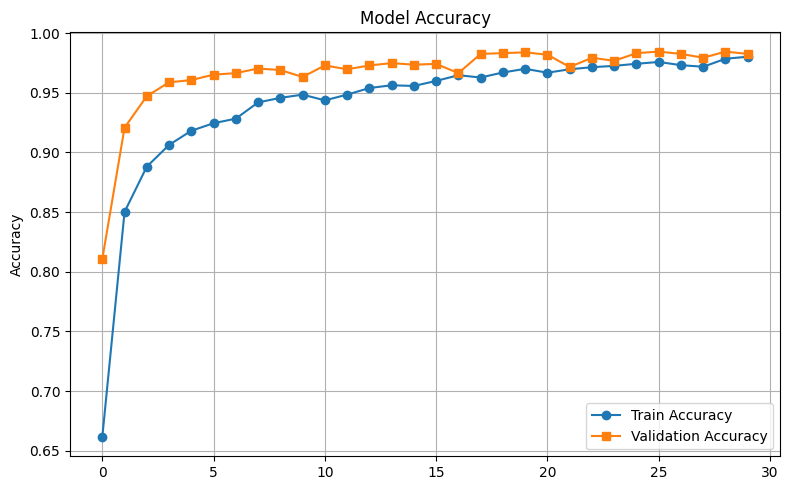

In [8]:
import pickle
import matplotlib.pyplot as plt

# 📦 Load fine-tuning history
with open('/content/drive/MyDrive/fine_tune_100_history.pkl', 'rb') as f:
    history = pickle.load(f)

# ✅ Print final accuracies
final_train_acc = history['accuracy'][-1]
final_val_acc = history['val_accuracy'][-1]
print(f"✅ Final Training Accuracy   : {final_train_acc*100:.2f}%")
print(f"✅ Final Validation Accuracy : {final_val_acc*100:.2f}%")

# 📈 Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('')  # No 'Epoch' on x-axis
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# ✅ Print final accuracies
final_train_acc = history['accuracy'][-1]
final_val_acc = history['val_accuracy'][-1]
print(f"✅ Final Training Accuracy   : {final_train_acc*100:.2f}%")
print(f"✅ Final Validation Accuracy : {final_val_acc*100:.2f}%")


✅ Final Training Accuracy   : 98.03%
✅ Final Validation Accuracy : 98.26%


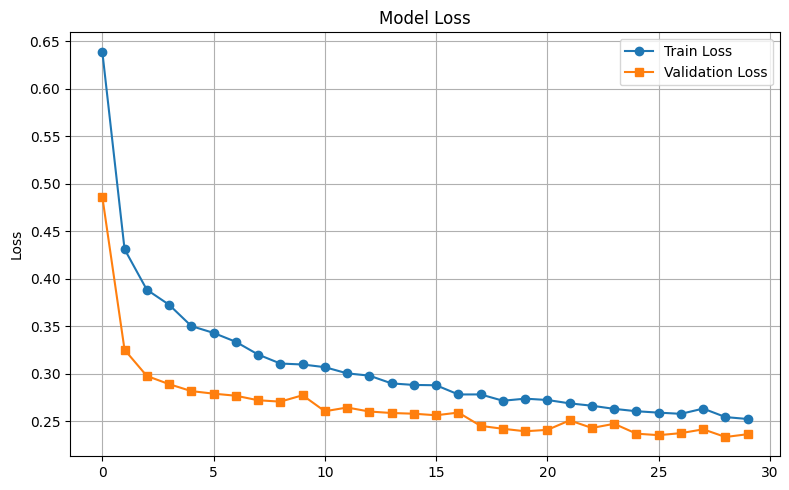

In [11]:
# 📉 Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history['loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from sklearn.metrics import accuracy_score

# ------------------ CONFIG ------------------ #
model_path = '/content/drive/MyDrive/fine_tune_100_final_model.h5'
test_dir = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split/test'
input_shape = (224, 224)
batch_size = 32

# ------------------ LOAD MODEL ------------------ #
model = load_model(model_path)

# ------------------ DATA LOADER ------------------ #
test_datagen = ImageDataGenerator(preprocessing_function=densenet_preprocess)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# ------------------ EVALUATE ------------------ #
loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")


Found 1556 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 712s 15s/step - accuracy: 0.9858 - loss: 0.2262

✅ Test Accuracy: 98.39%


49/49 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step

🔍 Best Threshold (Youden's J): 0.33

🧮 Confusion Matrix Breakdown:
🔹 True Positives (TP): 1127
🔹 True Negatives (TN): 409
🔹 False Positives (FP): 6
🔹 False Negatives (FN): 14

📊 Averaged Model Metrics (Threshold = 0.33):
✅ Accuracy : 0.9871
🎯 Precision: 0.9947
🔁 Recall   : 0.9877
📈 F1 Score : 0.9912


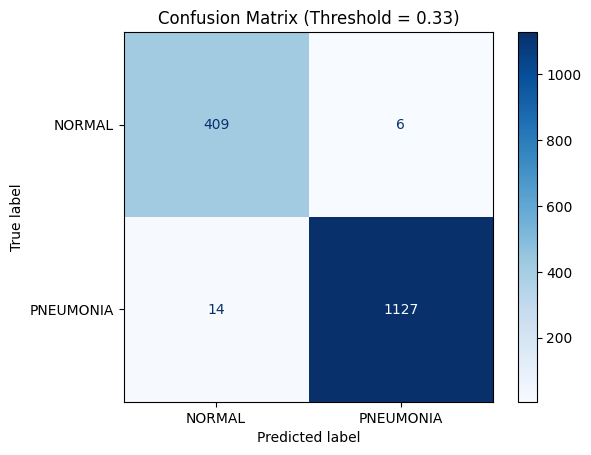

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

# Step 1: Get true labels
y_true = test_generator.classes

# Step 2: Predict probabilities
y_probs = model.predict(test_generator, verbose=1)

# Step 3: Compute best threshold using Youden’s J
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
youden_index = tpr - fpr
best_thresh = thresholds[np.argmax(youden_index)]
print(f"\n🔍 Best Threshold (Youden's J): {best_thresh:.2f}")

# Step 4: Apply threshold
y_pred = (y_probs > best_thresh).astype(int).reshape(-1)

# Step 5: Confusion Matrix + TP, TN, FP, FN
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n🧮 Confusion Matrix Breakdown:")
print(f"🔹 True Positives (TP): {tp}")
print(f"🔹 True Negatives (TN): {tn}")
print(f"🔹 False Positives (FP): {fp}")
print(f"🔹 False Negatives (FN): {fn}")

# Step 6: Overall Metrics
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall    = recall_score(y_true, y_pred, average='binary')
f1        = f1_score(y_true, y_pred, average='binary')

print(f"\n📊 Averaged Model Metrics (Threshold = {best_thresh:.2f}):")
print(f"✅ Accuracy : {accuracy:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"🔁 Recall   : {recall:.4f}")
print(f"📈 F1 Score : {f1:.4f}")

# Step 7: Plot Confusion Matrix
labels = list(test_generator.class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Threshold = {best_thresh:.2f})")
plt.grid(False)
plt.show()


✅ Model loaded


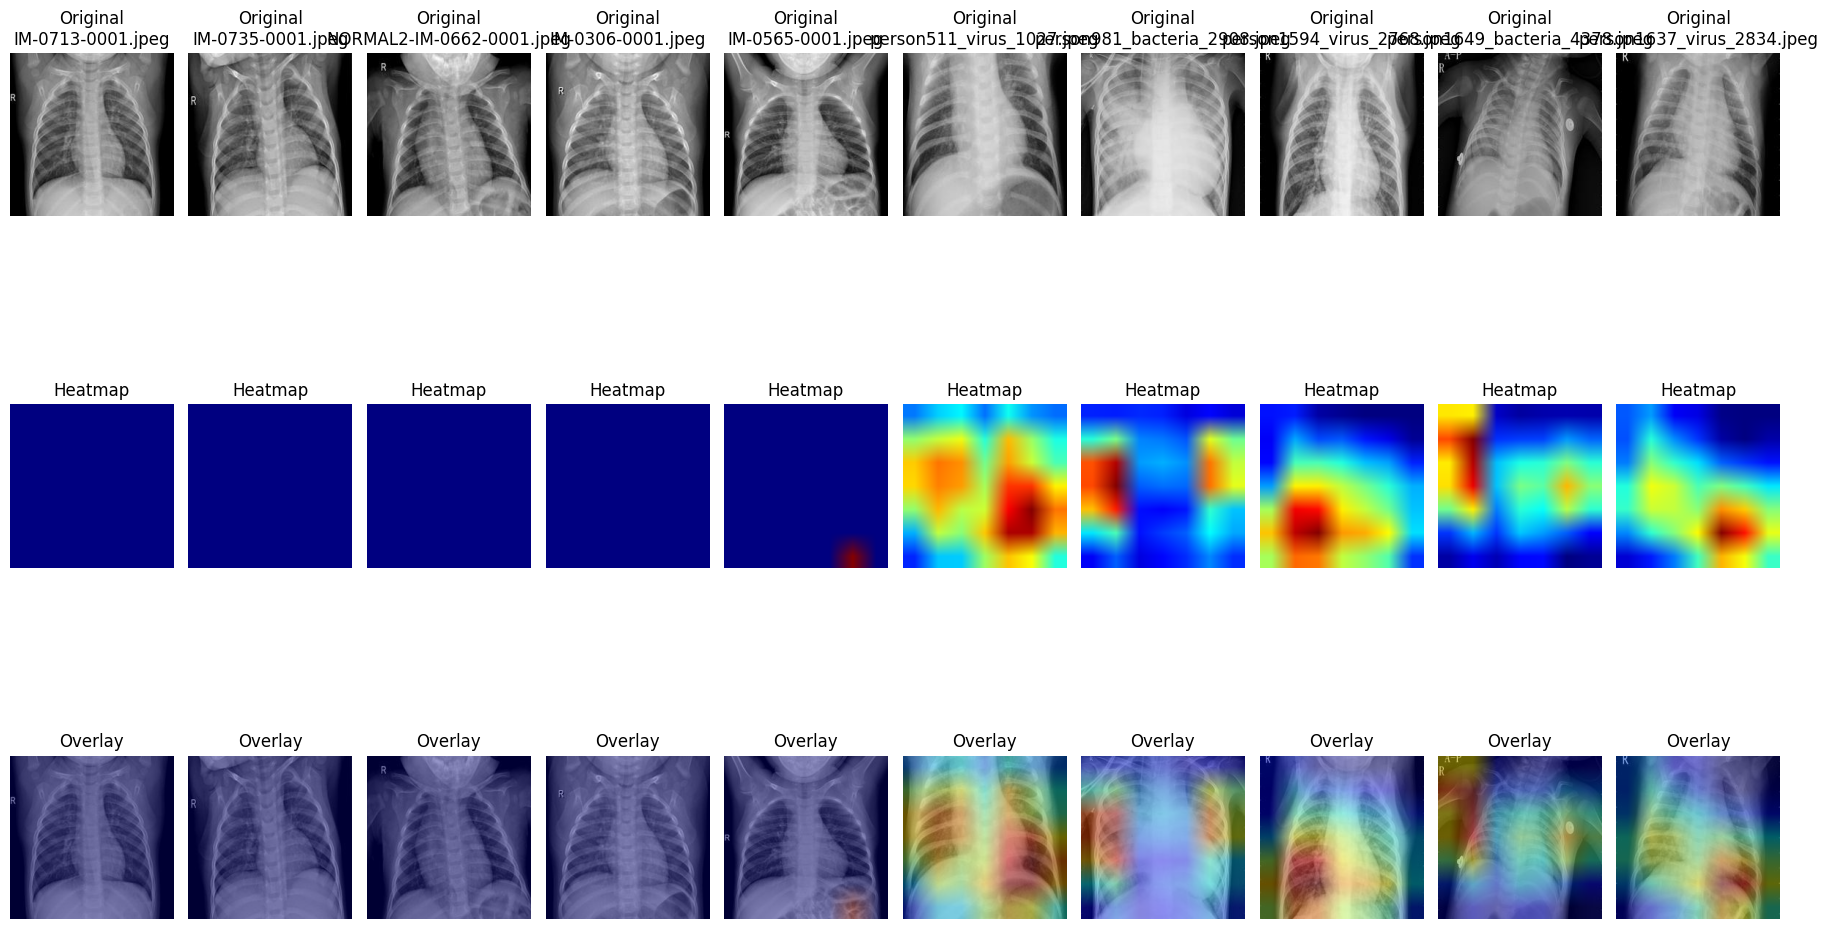

In [29]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input

# ✅ Paths and configs
model_path = '/content/drive/MyDrive/fine_tune_100_final_model.h5'
test_dir = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split/test'
layer_name = 'conv5_block16_concat'
num_images = 10

# ✅ Load model
model = load_model(model_path)
print("✅ Model loaded")

grad_model = Model(
    inputs=model.input,
    outputs=[model.get_layer(layer_name).output, model.output]
)

def compute_grad_cam(img_array):
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_output = predictions[:, 0]  # for binary classification

    grads = tape.gradient(class_output, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))
    conv_output = conv_output[0].numpy()
    pooled_grads = pooled_grads[0].numpy()

    cam = np.dot(conv_output, pooled_grads[..., np.newaxis]).squeeze()
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    return cam

def apply_grad_cam(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_display = np.array(img)

    # 🛠 Convert grayscale to RGB if needed
    if img_display.ndim == 2:
        img_display = cv2.cvtColor(img_display, cv2.COLOR_GRAY2RGB)
    elif img_display.shape[2] == 1:
        img_display = cv2.cvtColor(img_display, cv2.COLOR_GRAY2RGB)

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    cam = compute_grad_cam(img_array)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 🛠 Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img_display.shape[1], img_display.shape[0]))

    # ✅ Blend overlay safely
    overlay = cv2.addWeighted(img_display.astype('uint8'), 0.6, heatmap, 0.4, 0)
    return img_display, heatmap, overlay, os.path.basename(img_path)

# ✅ Pick 10 images: 5 from NORMAL and 5 from PNEUMONIA
image_paths = []
for label in ['NORMAL', 'PNEUMONIA']:
    img_list = os.listdir(os.path.join(test_dir, label))
    img_paths = random.sample(img_list, 5)
    image_paths.extend([os.path.join(test_dir, label, img) for img in img_paths])

# ✅ Visualize
plt.figure(figsize=(18, 12))
for i, img_path in enumerate(image_paths):
    try:
        original, heatmap, overlay, title = apply_grad_cam(img_path)

        plt.subplot(3, num_images, i + 1)
        plt.imshow(original)
        plt.title(f"Original\n{title}")
        plt.axis('off')

        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(heatmap)
        plt.title("Heatmap")
        plt.axis('off')

        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(overlay)
        plt.title("Overlay")
        plt.axis('off')

    except Exception as e:
        print(f"⚠️ Failed on {img_path}: {e}")

plt.tight_layout()
plt.show()
